<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/preprcing-learning/experiments/preprcing-learning/learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [スクラッチ]

In [ ]:
keras.backend.clear_session()
gc.collect()

# [環境構築]

In [1]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
import keras
import gc
from google.colab import drive
import os
import shutil


In [2]:
#@title gdrive マウント
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")


Mounted at /content/drive


In [3]:
#@title 一時的にファイルを置くディレクトリ'desk'を作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)

In [4]:
#@title 必要なファイルを'desk'にコピー
%%time
wants_paths = [
'/content/drive/MyDrive/colab/dence1223/key20201218.h5',
'/content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestVideos.npz'
]

for want in wants_paths:
  if not os.path.exists(os.path.join(desk, os.path.basename(want))):
    shutil.copy2(want, desk)
    print("get : ", want)
            

get :  /content/drive/MyDrive/colab/dence1223/key20201218.h5
get :  /content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTestLabels.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTestVideos.npz
CPU times: user 731 ms, sys: 1.76 s, total: 2.49 s
Wall time: 54.3 s


In [5]:
#@title データフォーマットを規定
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

# [データ用意・学習準備]

In [6]:
#@title 入力データの情報を規定
format1 = video_format()

colorSet = {'BW' : 1, 'RGB' : 3}

#入力層の設定
input_frameWIDTH = format1.WIDTH
input_frameHEIGHT = format1.HEIGHT
input_frameSIZE = format1.FRAME_SIZE
input_frameCOLOR = colorSet['RGB']
input_allPattern = input_frameWIDTH * input_frameHEIGHT * input_frameSIZE * input_frameCOLOR

print(
    input_frameWIDTH,
    input_frameHEIGHT,
    input_frameSIZE,
    input_frameCOLOR,
    input_allPattern )

80 45 30 3 324000


### [A-4-1-1]訓練データ用意


In [7]:
#@title 訓練データ用意
import numpy as np
import tensorflow as tf


v = np.load('/content/desk/normalTrainVideos.npz')
l = np.load('/content/desk/normalTrainLabels.npz')

train_videos = []
train_labels = []
for i in v.files:
  train_videos.append(v[i])
for i in l.files:
  train_labels.append(l[i])

train_videos = np.array(train_videos)
train_labels = np.array(train_labels)
train_labels = tf.keras.utils.to_categorical(train_labels, 4)

### [A-4-1-2]テストデータ用意


In [8]:
#@title テストデータ用意
import numpy as np

v = np.load('/content/desk/normalTrainVideos.npz')
l = np.load('/content/desk/normalTrainLabels.npz')

In [9]:
test_videos = []
test_labels = []
for i in v.files:
  test_videos.append(v[i])
for i in l.files:
  test_labels.append(l[i])

test_videos = np.array(test_videos)
test_labels = np.array(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels, 4)

In [10]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import os

def savePlot(fig, plus):
  # name = inv_losses[pick_loss]
  name = 'tmp'
  name = name + '_' + plus
  path_image = os.path.join(desk, name)
  fig.savefig(path_image)

def plotAcc(history):
  fig = plt.figure()
  ACC = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of ACCURACY',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  ACC.set(**props)
  acc = DataFrame(history.history['acc'])
  # val_acc = DataFrame(history.history['val_acc'])
  ACC.plot(acc, label='acc', marker='o', color='blue')
  # ACC.plot(val_acc, label='val_acc', marker='o', linestyle='--', color='orange')
  ACC.legend()

  savePlot(fig, 'acc')

def plotLoss(history):
  fig = plt.figure()
  LOSS = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of LOSS',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSS.set(**props)
  loss = DataFrame(history.history['loss'])
  # val_loss = DataFrame(history.history['val_loss'])
  LOSS.plot(loss, label='loss', marker='o', color='blue')
  # LOSS.plot(val_loss, label='val_loss', marker='o', linestyle='--', color='orange')
  LOSS.legend()

  savePlot(fig, 'loss')

一覧

In [11]:
# loss一覧
mse = tf.keras.losses.MeanSquaredError()
cce = tf.keras.losses.CategoricalCrossentropy()

# optimizer一覧
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.0, decay=0.0, nesterov=False)

# [[学習実行]]

In [ ]:
class mySGD:
  l

def learning(optimizer, loss):
  pass

if __name__ == '__main__':
  optimizer = 





Epoch 1/1024
9/9 [==============================] - 1s 80ms/step - loss: 0.2451 - acc: 0.1311 - categorical_crossentropy: 1.8725 - val_loss: 0.2230 - val_acc: 0.1550 - val_categorical_crossentropy: 1.6938
Epoch 2/1024
9/9 [==============================] - 1s 60ms/step - loss: 0.2189 - acc: 0.1625 - categorical_crossentropy: 1.7039 - val_loss: 0.2106 - val_acc: 0.1938 - val_categorical_crossentropy: 1.5888
Epoch 3/1024
9/9 [==============================] - 1s 60ms/step - loss: 0.2073 - acc: 0.2022 - categorical_crossentropy: 1.5887 - val_loss: 0.2034 - val_acc: 0.2248 - val_categorical_crossentropy: 1.5262
Epoch 4/1024
9/9 [==============================] - 1s 60ms/step - loss: 0.2062 - acc: 0.2071 - categorical_crossentropy: 1.5346 - val_loss: 0.1985 - val_acc: 0.3178 - val_categorical_crossentropy: 1.4783
Epoch 5/1024
9/9 [==============================] - 1s 59ms/step - loss: 0.2007 - acc: 0.2781 - categorical_crossentropy: 1.5002 - val_loss: 0.1932 - val_acc: 0.3101 - val_categori

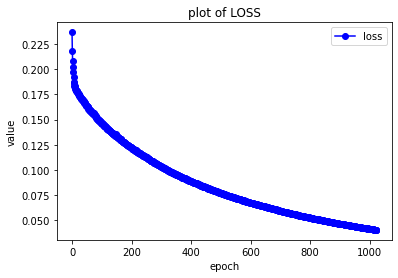

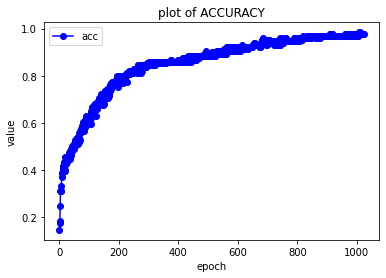

In [17]:
#学習設定
%%time
loss=mse
lr=0.00001


# モデル準備
model = models.load_model('/content/desk/key20201218.h5')

# コンパイル
model.compile(
    optimizer=keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False),
    loss=loss,
    metrics=['acc', cce])

# 実行
history = model.fit(
      train_videos, 
      train_labels, 
      validation_data=(test_videos, test_labels),
      batch_size=16,
      epochs=1024,
      # verbose=0
      )
print("Complete.")

# プロット
plotLoss(history)
plotAcc(history)

#[ストレージへ保存]

In [ ]:
shelf = '/content/drive/MyDrive/colab'
book = 'dence1223'
shelf_book = os.path.join(shelf, book)
if not os.path.exists(shelf_book):
  os.mkdir(shelf_book)   

In [ ]:
wants_paths = [
'/content/desk/normalTestLabels.npz',
'/content/desk/normalTestVideos.npz'
]    

for want in wants_paths:
  shutil.copy2(
      want,
      shelf_book
  )

#[掃き溜め]

In [ ]:
%tensorflow_version 2.x
!pip2 install --upgrade google-auth-oauthlib grpcio >/dev/null 2>&1
import shutil
from tensorflow.keras import layers, models, initializers, callbacks
log_dir = '/tmp/log'
shutil.rmtree(log_dir, ignore_errors=True)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir,
                                             histogram_freq=1)

In [ ]:
losses = {
    'CCE' : 'categorical_crossentropy',
    'SCE' : 'sparse_categorical_crossentropy',

    'MSE' : 'mean_squared_error',
    'MSLE' : 'mean_squared_logarithmic_error',
    'MAE' : 'mean_absolute_error',
}
def inverse_dict(d):
    return {v:k for k,v in d.items()}

inv_losses = inverse_dict(losses)


In [ ]:
#@title 学習
%%time
history = model.fit(
      train_videos, train_labels, 
      validation_data=(test_videos, test_labels),
      batch_size=16, epochs= 30,
      # callbacks=[tensorboard_callback]
      )
print("Complete.")

In [ ]:
!curl -OL https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://6b5d01d27e35.ngrok.io
